# 7.2コンバージョンテスト

In [1]:
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

In [4]:
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A,
                  beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
                  beta_prior + visitors_to_B - conversions_from_B)

In [5]:
samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

print((samples_posterior_A > samples_posterior_B).mean())

0.3098


(0.05, 0.15)

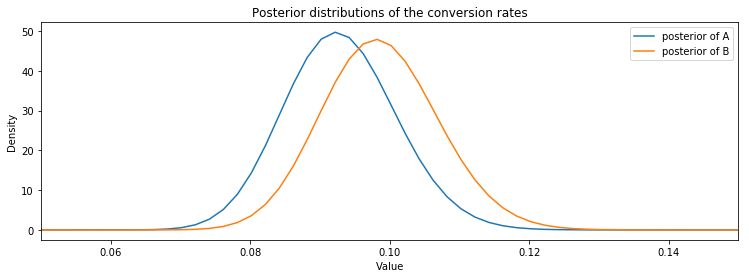

In [7]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
figsize(12.5, 4)

x = np.linspace(0, 1, 500)
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distributions of the conversion rates')
plt.legend()
plt.xlim(0.05, 0.15)

# 7.3
## 7.3.1

In [8]:
from numpy.random import multinomial
P = [0.5, 0.2, 0.3]
N = 1
print(multinomial(N, P))

[0 0 1]


In [9]:
N = 10
print(multinomial(N, P))

[7 1 2]


In [11]:
from numpy.random import dirichlet

sample = dirichlet([1,1,1,1])
print(sample)
print(sample.sum())

[ 0.05615642  0.30903652  0.47905706  0.15575   ]
1.0


In [12]:
N =  1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1, 1, 1, 1])
posterior_samples = dirichlet(prior_parameters + observations, size=10000)

print("Two random samples from the posterior:")
print(posterior_samples[0])
print(posterior_samples[1])

Two random samples from the posterior:
[ 0.00837894  0.05741081  0.08838563  0.84582463]
[ 0.01084299  0.04061448  0.09571703  0.8528255 ]


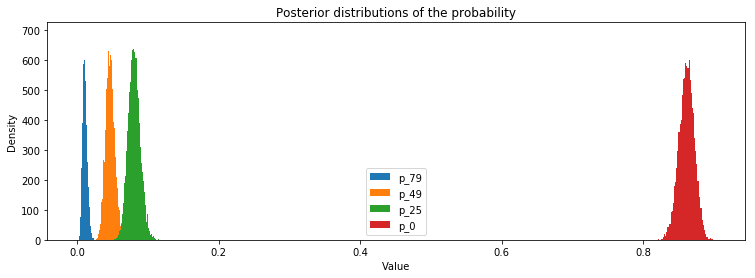

In [13]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    plt.hist(posterior_samples[:, i], bins=50, label=label, histtype='stepfilled')
    
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the probability")
plt.legend()

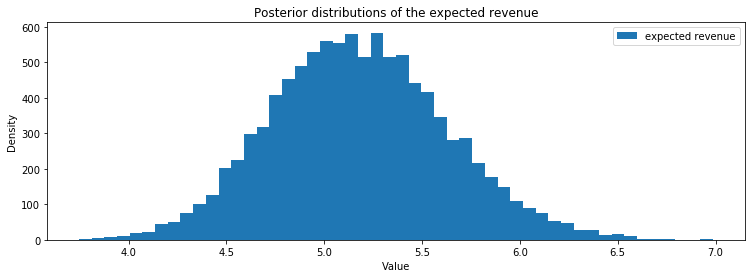

In [14]:
def expected_revenue(P):
    return 79 * P[:,0] + 49 * P[:,1] + 25 * P[:,2] + 0 * P[:,3]

posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, histtype='stepfilled', bins= 50, label='expected revenue')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the expected revenue")
plt.legend()

## 7.3.2

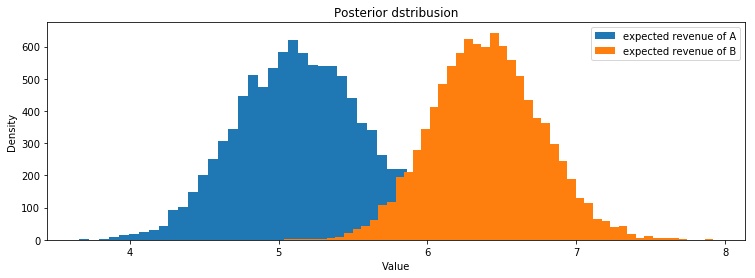

In [16]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)

posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled', label='expected revenue of A', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled', label='expected revenue of B', bins=50)

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Posterior dstribusion')
plt.legend()


In [18]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print('Probability that page B has a higher revenue than page A: %.3f' % p)

Probability that page B has a higher revenue than page A: 0.982


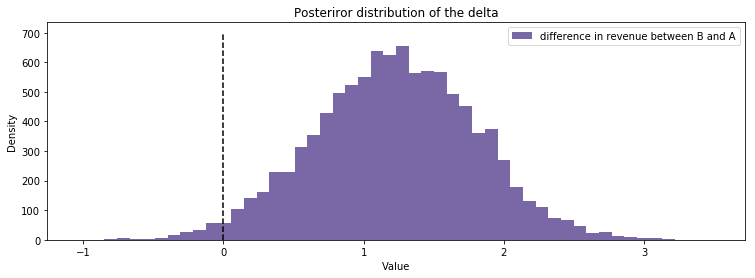

In [20]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6', bins=50, label='difference in revenue between B and A')
plt.vlines(0,0,700, linestyles ='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posteriror distribution of the delta')
plt.legend()

# 7.4
## 7.4.1

In [21]:
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 26, 7

durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

In [22]:
print(durations_A[:8])
print(durations_B[:8])

[ 33.40801549  33.568987    30.79830472  31.82136982  23.38845987
  29.64979603  31.30689226  30.26873212]
[ 26.21111008  18.08369371  30.75865857  19.67178466  24.98526935
  23.35306487  17.56448277  22.3691431 ]


1.${\mu}_A$ と ${\mu}_B$ の事前分布は正規分布とする。その平均はAとBのデータの平均、標準偏差はデータの標準偏差の1000倍にする（このため分布は非常に広くなり、実質的に無情報慈善分布になる)

In [24]:
import pymc as pm

pooled_mean = np.r_[durations_A, durations_B].mean()
pooled_std = np.r_[durations_A, durations_B].std()

# PyMCでは標準偏差ではなく精度を使う（よくわからん）
tau = 1. / np.sqrt(1000. * pooled_std)

mu_A = pm.Normal("mu_A", pooled_mean, tau)
mu_B = pm.Normal("mu_B", pooled_mean, tau)

2.${\sigma}_A$と${\sigma}_B$の事前分布 は一様分布とする。その範囲は、データの標準偏差の1/1000倍から1000倍までとする

In [26]:
std_A = pm.Uniform("std_A", pooled_std / 1000., 1000. * pooled_std)
std_B = pm.Uniform("std_B", pooled_std / 1000., 1000. * pooled_std)

3.${\nu}$は、右に1だけシフトした指数分布(パラメータは29とする)に従うとする。

In [28]:
nu_minus_1 = pm.Exponential("nu-1", 1. / 29)

In [30]:
obs_A = pm.NoncentralT("obs_A", mu_A, 1.0/std_A**2, nu_minus_1 + 1, observed=True, value=durations_A)
obs_B = pm.NoncentralT("obs_B", mu_B, 1.0/std_B**2, nu_minus_1 + 1, observed=True, value=durations_B)
mcmc = pm.MCMC([obs_A, obs_B, mu_A, mu_B, std_A, std_B, nu_minus_1])
mcmc.sample(25000, 10000)

 [-----------------100%-----------------] 25000 of 25000 complete in 10.0 sec

/Users/hiroki/.pyenv/versions/anaconda3-4.0.0/envs/py3_personal/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


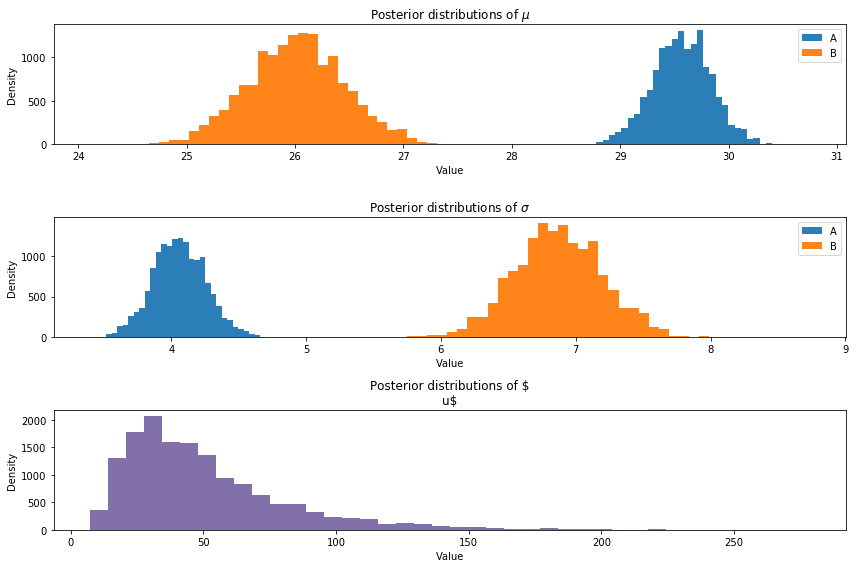

In [33]:
mu_A_trace = mcmc.trace('mu_A')[:]
mu_B_trace = mcmc.trace('mu_B')[:]
std_A_trace = mcmc.trace('std_A')[:]
std_B_trace = mcmc.trace('std_B')[:]
nu_trace = mcmc.trace("nu-1")[:] + 1

figsize(12,8)

def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled', alpha=.95, label=label, **kwargs)

ax = plt.subplot(3,1,1)
_hist(mu_A_trace, 'A')
_hist(mu_B_trace, 'B')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distributions of $\mu$')


ax = plt.subplot(3,1,2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distributions of $\sigma$')

ax = plt.subplot(3,1,3)
_hist(nu_trace, '', color='#7A68A6')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distributions of $\nu$')
plt.tight_layout()